# Classifier selection
Training data should be all set, let's take a quick look for sanity and then dig into building the text classifier. Plan here is to try a bunch of different things, follow any interesting ideas or insights and see what sticks. Some thoughts to get started:

1. ~~Should we use the DMLC XGBoost package or the gradient boosting classifier included in scikit-learn?~~ Use XGBoost via the scikit-learn API, classification performance is similar to scikit-learn's gradient boosting classifier, but it's much faster.

2. ~~Binary cross entropy seems like the obvious loss function to use, but what metrics should we track?~~

    - The default for XGBoost on this type of task is '**binary:logistic**' - but I haven't found exactly what that loss function is yet...
    - For scikit-learn gradient boosting classifier the default is '**log_loss**' which, according to the documentation 'refers to binomial and multinomial deviance, the same as used in logistic regression'.

    Ok, fine - only way I see to confirm that those are the same is dig into the source code. Definitely not worth the effort. At the end of the day, exactly what/how it is optimized and if it's the same between the two frameworks does not really matter - what we need is a way to evaluate both of them.

    I like false positive and false negative rates, we can get those from the confusion matrix (and also plot that at the same time). We should probably include accuracy as a percent for the less-statistically minded. We need a third to give a good look at the underlying probabilities rather than the 'calls'. Let's go with binary cross-entropy, in scikit-learn the **log_loss**.
    
3. ~~Do some hyperparameter tuning.~~ Done.
4. ~~Make sure we can do k-fold cross validation rather than looking at the test data all the time.~~ Done.
5. ~~Is there an easy way to do early stopping?~~ Yep - it's built into the sklearn API.
6. Is there an easy way to make training plots (i.e. training & validation loss over time)?
7. What about random forest?
8. Take a look at examples we have a hard time with.
9. ~~Take a look at feature importance.~~
10. Maybe throw in some other methods (i.e. deep neural network/logistic regression), just for completeness.
11. ~~Build a results data structure so we can track the winners at each stage.~~ Done.

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

import pandas as pd
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

/mnt/arkk/llm_detector/classifier


## Load and prepare data

In [2]:
# The dataset - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
working_hdf5_file = f'{config.DATA_PATH}/{dataset_name}_stage_I_experimental.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(working_hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Take small sample for rapid development and testing
data_df = data_df.sample(n = 5000)

# Close hdf5 connection
data_lake.close()

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 42246 to 40297
Data columns (total 26 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Fragment ID                                                                       5000 non-null   int64  
 1   Source record num                                                                 5000 non-null   int64  
 2   Fragment length (words)                                                           5000 non-null   int64  
 3   Fragment length (tokens)                                                          5000 non-null   int64  
 4   Dataset                                                                           5000 non-null   object 
 5   Source                                                                            5000 non-null   object 
 6   

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,...,Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score,Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score,Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
42246,42246,10412,136,207,pubmed,synthetic,llama2-13b,the broader society .\nThe goal is to represen...,2.450,2.960938,...,0.331763,3.796868,0.328229,-1.913224,-1.748622,0.602746,0.035418,0.073481,0.046544,0.077477
19966,19966,8546,104,138,cnn,synthetic,llama2-13b,people have been forced from their homes since...,3.064,3.257812,...,1.249379,0.403340,1.355444,-3.410278,-3.371311,0.264257,0.072187,0.038176,0.091455,0.038346
53622,53622,10114,215,289,pubmed,synthetic,llama2-13b,attributed to an alteration in the atmospheric...,2.730,3.009766,...,0.340422,1.575608,0.272412,-2.954446,-3.280581,-2.033456,0.156036,0.031400,0.110825,0.031595
4989,4989,9819,53,100,pubmed,synthetic,llama2-13b,"of atg7 , the catalytic subunit of atg5 , and ...",2.545,3.060547,...,0.303924,3.894371,0.307357,-2.115599,-2.347902,-1.036882,0.228786,0.017372,0.208535,0.019001
13799,13799,9598,198,306,pubmed,synthetic,llama2-13b,"often found to coexist with asthma, and this c...",2.016,2.333984,...,0.113502,3.648252,0.135192,-2.853602,-2.948407,-0.550064,0.191751,0.010522,0.205624,0.011721


OK, let's get the data into shape to train a classifier.

In [4]:
# Split the data into training and testing
training_data_df = data_df.sample(frac = 0.7, random_state = 42)
testing_data_df = data_df.drop(training_data_df.index)

# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50].copy()
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary and un-trainable
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Keep a dataframe copy of the features for easy manipulation later and make 
# a numpy copy for training without the dataset or string columns
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

print(f'Training data: {len(features_train_df)} examples')
print(f'Test data: {len(features_test_df)} examples')


Training data: 2780 examples
Test data: 1210 examples


Take a look at the features we are working with:

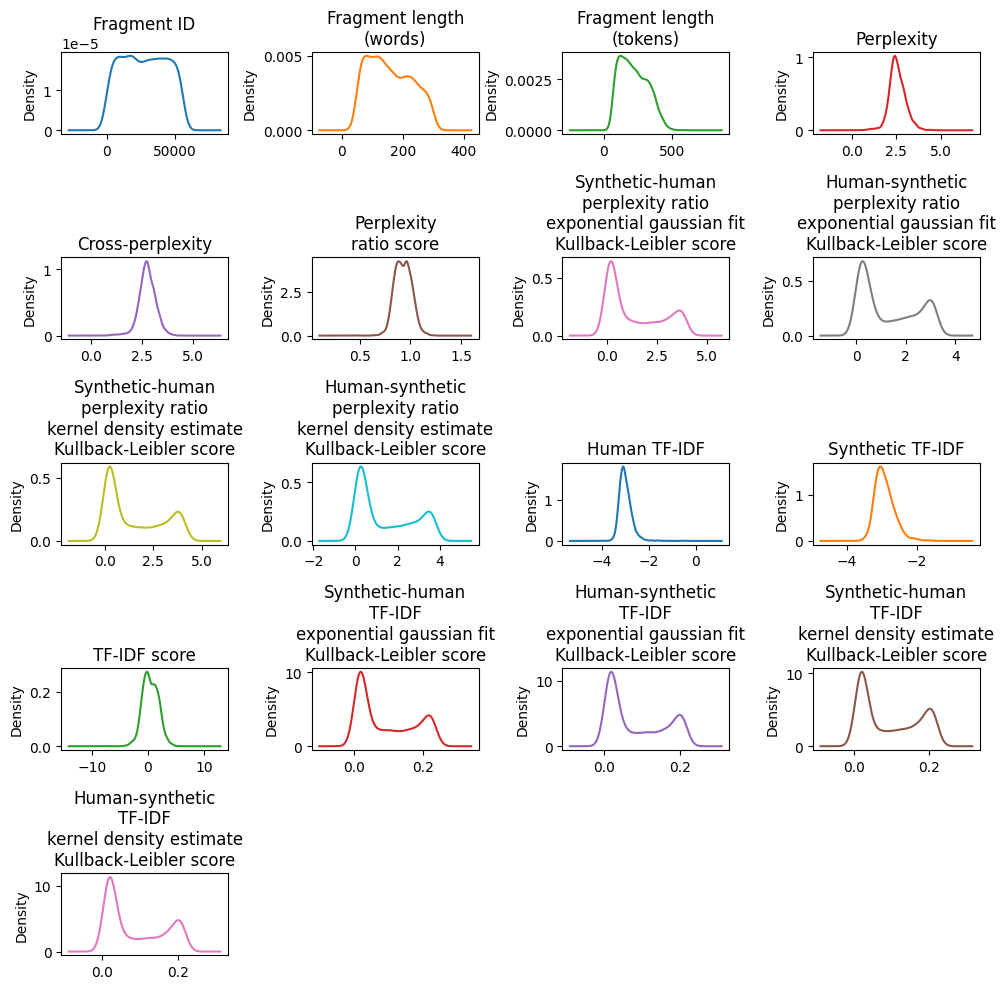

In [6]:
plot_funcs.plot_feature_distributions(features_train_df).show()

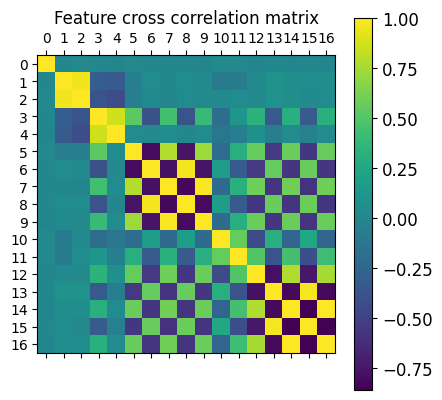

In [7]:
plot_funcs.plot_cross_correlation_matrix(features_train_df).show()

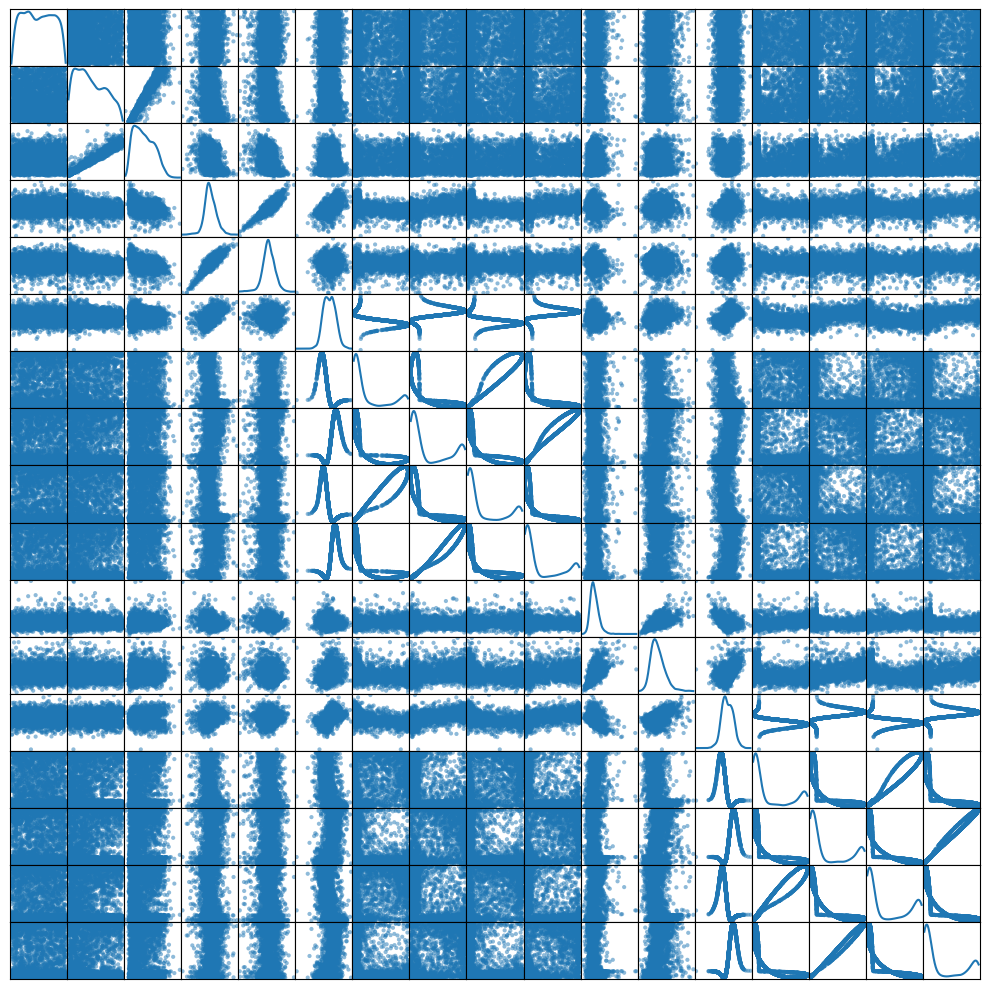

In [8]:
plot_funcs.plot_scatter_matrix(features_train_df).show()

Let's also make a data structure to collect results for plotting as we go.

In [9]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

## 3. Off-the-shelf classifiers

In [10]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

In [11]:
# Some parameters
kfolds = 3
random_state = 23
parallel_jobs = 16

### 2.1. XGBoost XGBClassifier

In [12]:
%%time 

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'XGBC')

Model is: <class 'xgboost.sklearn.XGBClassifier'>

CPU times: user 57.5 ms, sys: 225 ms, total: 283 ms
Wall time: 4.59 s


### 2.2. scikit-learn GradientBoostingClassifier

In [13]:
%%time

# Instantiate sklearn gradient boosting classifier
model = GradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'GBC')

Model is: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>

CPU times: user 13.9 ms, sys: 8.44 ms, total: 22.3 ms
Wall time: 3.64 s


### 2.3. scikit-learn HistGradientBoostingClassifier

In [14]:
%%time

from sklearn.ensemble import HistGradientBoostingClassifier

# Instantiate sklearn gradient boosting classifier
model = HistGradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'HGBC')

Model is: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>

CPU times: user 18 ms, sys: 2.82 ms, total: 20.8 ms
Wall time: 2.82 s


### 2.4. Results

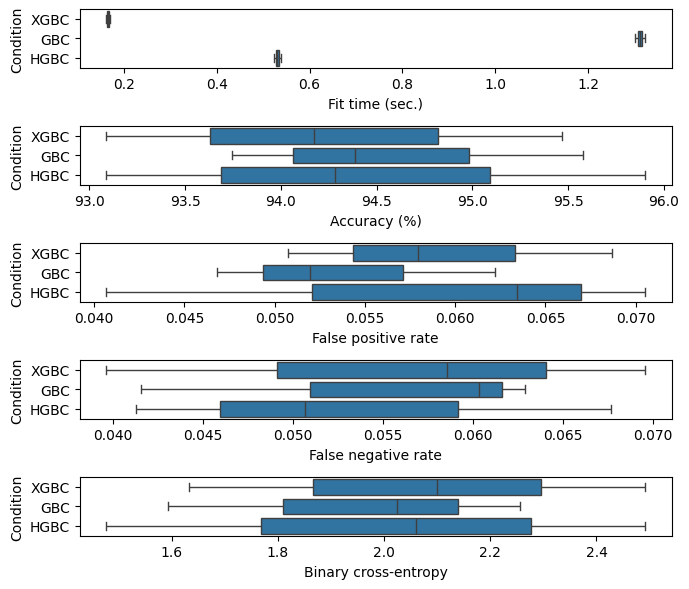

In [15]:
plot_funcs.plot_cross_validation(plots, results).show()

OK, pretty good - we are not over-fitting or just guessing the major class, we are in the mid-low 90% accuracy for all three implementation. This is actually a pretty good bump over the LLaMA2 based perplexity ratio score where we never got better than 88%. Problem now is as before, high false positive rate ~8% for all three implementations. We may be able to mitigate that somewhat at the cost of false negatives with some threshold tuning later. First let's do some:

## 3. Hyperparameter optimization

In [17]:
# How many iterations to run
n_iter = 10

# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'max_iter': scope.int(hp.quniform('max_iter', 10, 1000, 1)),
       'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 15, 60, 1)),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 1000, 1)),
       'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 100, 1)),
       'l2_regularization': hp.uniform('l2_regularization', 0.001, 1.0)
}

### 3.1. HistGradientBoostingClassifier: single training-validation split

In [18]:
# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 10/10 [00:00<00:00, 12.00trial/s, best loss: 1.8151480124015833]


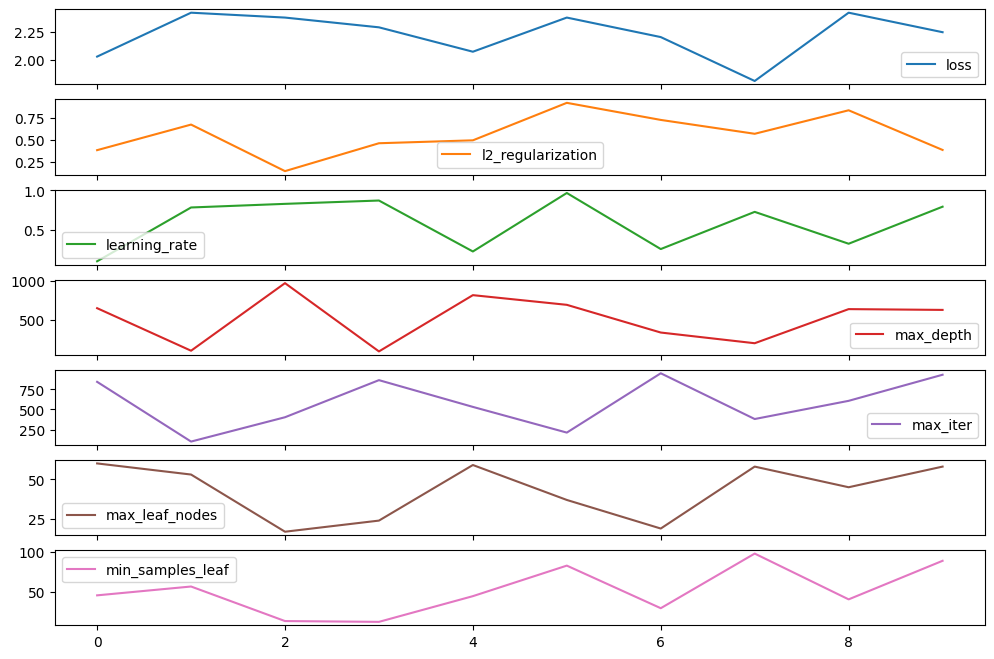

In [19]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [20]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best['learning_rate'],
    max_iter = int(best['max_iter']),
    max_leaf_nodes = int(best['max_leaf_nodes']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    l2_regularization = best['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized HGBC')


Optimized parameters:

 l2_regularization: 0.5709516472592204
 learning_rate: 0.7277629700515903
 max_depth: 205.0
 max_iter: 382.0
 max_leaf_nodes: 58.0
 min_samples_leaf: 98.0



### 3.2. HistGradientBoostingClassifier with k-fold cross validation

In [21]:
# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

# Set up trial logging
trials_cv = Trials()

best_cv = fmin(
       fn = partial(
              helper_funcs.hyperopt_cv,
              model = model,
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials_cv       # Logging
)

100%|██████████| 10/10 [00:21<00:00,  2.14s/trial, best loss: 2.035558842478918]


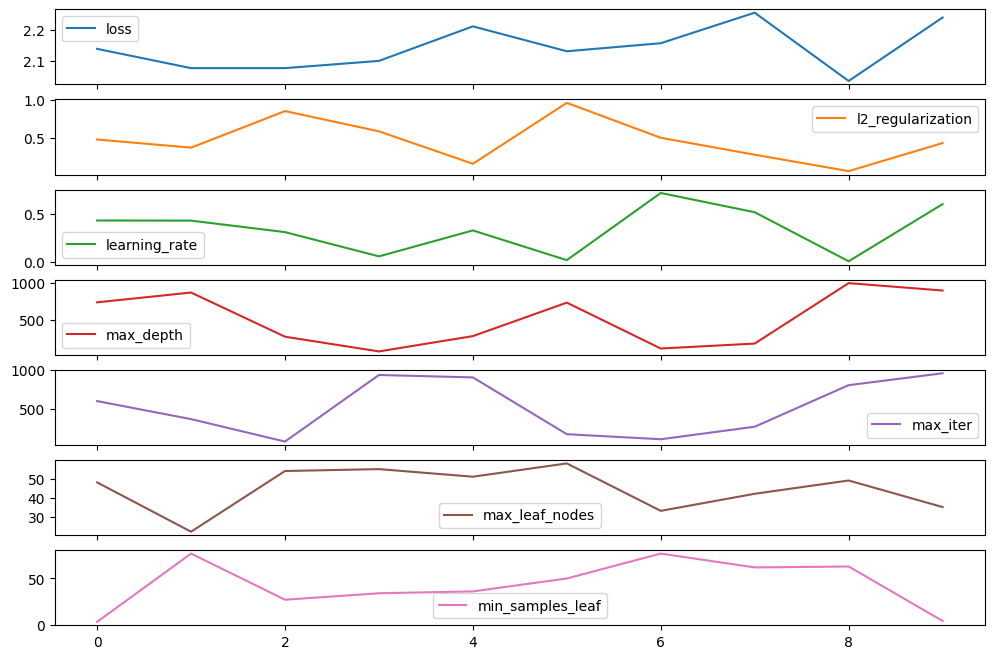

In [22]:
optimization_plot = plot_funcs.make_optimization_plot(trials_cv.trials)

In [23]:
print('Optimized parameters:\n')

for key, value in best_cv.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best_cv['learning_rate'],
    max_iter = int(best_cv['max_iter']),
    max_leaf_nodes = int(best_cv['max_leaf_nodes']),
    max_depth = int(best_cv['max_depth']),
    min_samples_leaf = int(best_cv['min_samples_leaf']),
    l2_regularization = best_cv['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'CV Optimized HGBC')

Optimized parameters:

 l2_regularization: 0.07405534917356511
 learning_rate: 0.0029560645650717654
 max_depth: 997.0
 max_iter: 804.0
 max_leaf_nodes: 49.0
 min_samples_leaf: 63.0



### 3.3. XGBClassifier: single training-validation split

In [24]:
# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'gamma': hp.uniform('gamma', 0.0, 10.0),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 1)),
       'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
       'subsample': hp.uniform('subsample', 0.5, 1.0),
       'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
       'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
       'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
       'num_parallel_tree': scope.int(hp.quniform('num_parallel_tree', 1, 10, 1))
}

# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = XGBClassifier()

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 10/10 [00:05<00:00,  1.93trial/s, best loss: 1.7287123927634125]


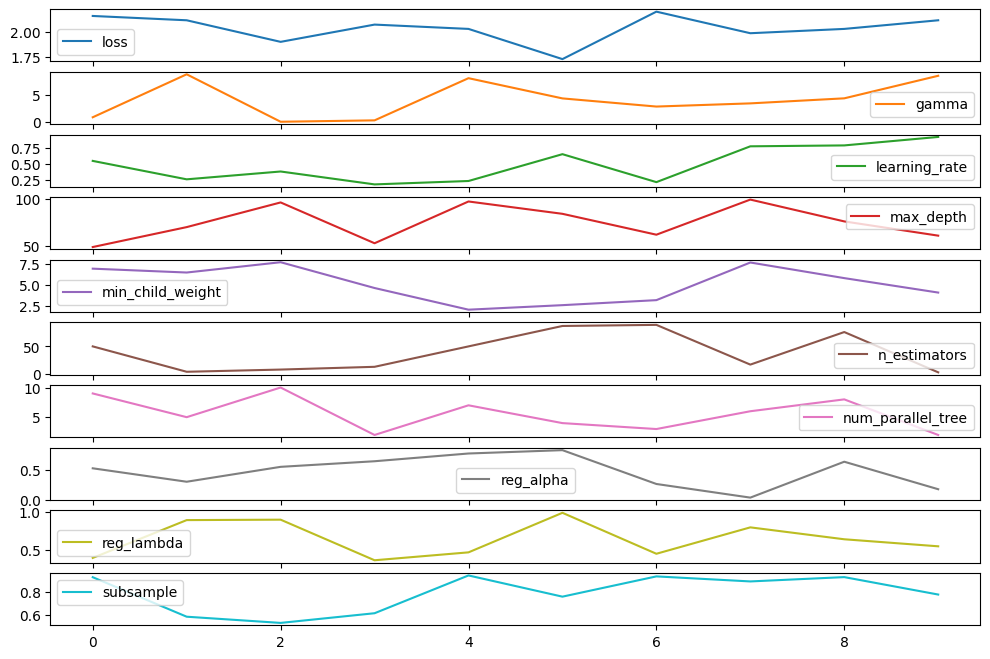

In [25]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [26]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = XGBClassifier(
    learning_rate = best['learning_rate'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = int(best['reg_lambda']),
    n_estimators = int(best['num_parallel_tree'])
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized XGBC')


Optimized parameters:

 gamma: 4.375081804437794
 learning_rate: 0.6534422040033232
 max_depth: 84.0
 min_child_weight: 2.622920620682172
 n_estimators: 87.0
 num_parallel_tree: 4.0
 reg_alpha: 0.8187770382707695
 reg_lambda: 0.9916572888034284
 subsample: 0.758539043672043



### 3.4. Results

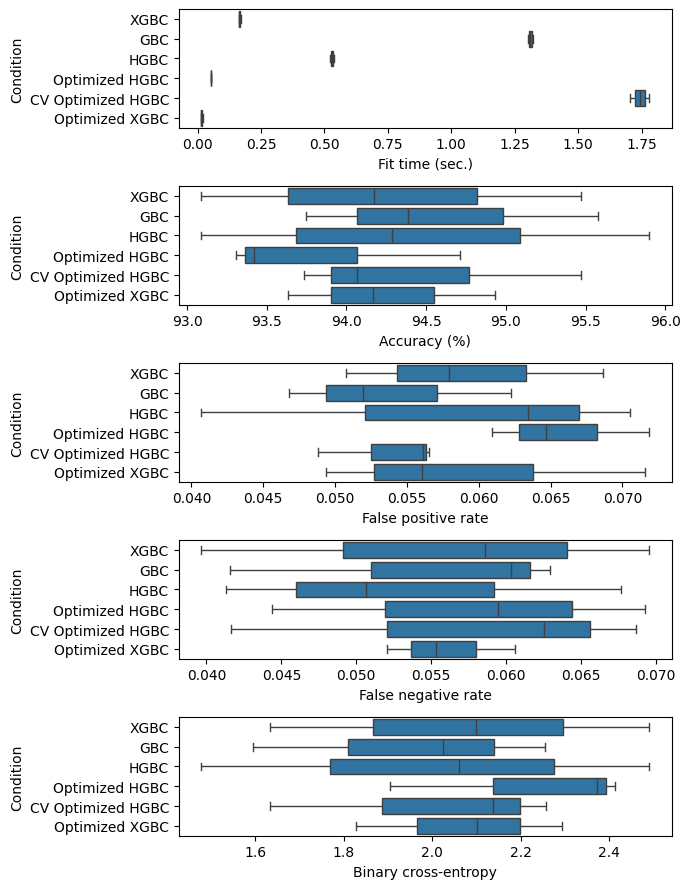

In [27]:
plot_funcs.plot_cross_validation(plots, results).show()

Looks like the optimized *HistGradientBoostingClassifier* is the winner. Let's train it on all of the training data with the optimized hyperparameters and then evaluate it on the held-out test set.

In [28]:
# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = 0.030273254048394146,
    max_iter = 778,
    max_leaf_nodes = 22,
    max_depth = 856,
    min_samples_leaf = 35,
    l2_regularization = 0.5527326637182666,
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10
)

model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
#predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, y_pred)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 93.7%


Ouch, we got killed on the test set somehow... We are over fitting? Despite the cross-validation? Hmmm...


Confusion matrix:
[[583  35]
 [ 41 551]]

Normalized confusion matrix:


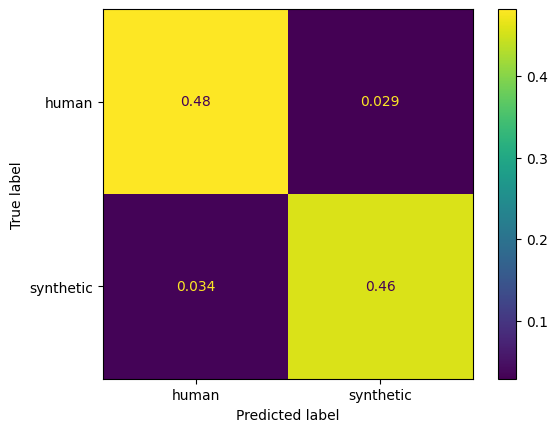

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(labels_test, y_pred)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    features_test, 
    labels_test, 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)

Next, let's take a look at feature importance and see if we really need exponential gaussian fit and kernel density estimate Kullback-Leibler features in both directions, i.e. human -> synthetic and synthetic -> human...